In [ ]:
# default_exp distanceApproaches

In [2]:
# export
from multiinstance.utils import *

import seaborn as sns

import community as community_louvain
import networkx as nx

from multiinstance.data.syntheticData import buildDataset,getBag
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity
from scipy.special import logsumexp
import scipy.stats as ss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
# export

def addTransformScores(ds):
    P,U = list(zip(*[ds.getBag(i) for i in range(len(ds.numP))]))

    P = np.concatenate(P)
    U = np.concatenate(U)

    X = np.concatenate((P,U))
    Y = np.concatenate((np.ones(P.shape[0]),
                        np.zeros(U.shape[0])))

    clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples=X.shape[0],
                            max_features=X.shape[1], bootstrap=True, bootstrap_features=False, oob_score=True).fit(X,Y)

    probP = clf.oob_decision_function_[:,1]

    roc_auc_score(Y, probP)

    Pprobs, Uprobs = splitIntoBags(probP,ds.numP, ds.numU)
    ds.Pprobs = Pprobs
    ds.Uprobs = Uprobs
    return ds

def splitIntoBags(probs, numP, numU):
    probsP, probsU = probs[:numP.sum()], probs[numP.sum():]
    pUpperIndices = np.concatenate(([0],np.cumsum(numP)))
    uUpperIndices = np.concatenate(([0],np.cumsum(numU)))
    P = np.zeros((len(numP), numP.max()))
    U = np.zeros((len(numU), numU.max()))
    for b in range(len(numP)):
        P[b,:numP[b]] = probsP[pUpperIndices[b]:pUpperIndices[b+1]]
        U[b,:numU[b]] = probsU[uUpperIndices[b] : uUpperIndices[b+1]]
    return P,U

def getTransformScores(ds,i):
    p = ds.Pprobs[i,:ds.numP[i]]
    u = ds.Uprobs[i,:ds.numU[i]]
    return p,u

In [5]:
# export
def fitKDE(vec):
    kde = KernelDensity(kernel="gaussian").fit(vec)
    return kde

def KLD(lnDensI,lnDensJ):
        return ss.entropy(np.exp(lnDensI), qk=np.exp(lnDensJ),base=2)
    
def JSD(ds, kdeI, i, j):
    _,uI = getTransformScores(ds,i)
    uI = uI.reshape((-1,1))
    _,uJ = getTransformScores(ds,j)
    uJ = uJ.reshape((-1,1))
    kdeJ = fitKDE(uJ)
    lnDensI0 = kdeI.score_samples(uI)
    lnDensJ0 = kdeJ.score_samples(uI)
    lnDensM0 = np.array([logsumexp((ldi,ldj),
                                       b=np.array([.5,.5])) for ldi,ldj in zip(lnDensI0, lnDensJ0)])
    lnDensI1 = kdeI.score_samples(uJ)
    lnDensJ1 = kdeJ.score_samples(uJ)
    lnDensM1 = np.array([logsumexp((ldi,ldj),
                                       b=np.array([.5,.5])) for ldi,ldj in zip(lnDensI1, lnDensJ1)])
    x = KLD(lnDensI0,lnDensM0)
    y = KLD(lnDensJ1, lnDensM1)
    return x + y

def getJSDDistMat(ds):
    N = ds.N
    dist = np.zeros((N,N))
    for i in range(N):
        _, uI = getTransformScores(ds,i)
        kdeI = fitKDE(uI.reshape((-1,1)))
        for j in range(i+1, N):
            jsd = JSD(ds, kdeI, i,j)
            dist[i,j] = jsd
            dist[j,i] = jsd
    return dist

def getKLDMat(ds):
    N = ds.N
    dist = np.zeros((N,N))
    for i in range(N):
        _, uI = getTransformScores(ds,i)
        uI = uI.reshape((-1,1))
        kdeI = fitKDE(uI)
        for j in range(N):
            _,uJ = getTransformScores(ds,j)
            uJ = uJ.reshape((-1,1))
            kdeJ = fitKDE(uJ)
            lnDensI = kdeI.score_samples(uI)
            lnDensJ = kdeJ.score_samples(uI)
            dist[i,j] = KLD(lnDensI, lnDensJ)
    return dist

def getWassersteinMat(ds):
    N = ds.N
    dist = np.zeros((N,N))
    for i in range(N):
        _, uI = getTransformScores(ds,i)
#         uI = uI.reshape((-1,1))
        for j in range(N):
            _,uJ = getTransformScores(ds,j)
#             uJ = uJ.reshape((-1,1))
            dist[i,j] = ss.wasserstein_distance(uI,uJ)
    return dist

def getOptimalAdjacency(trueAlphas):
    N = trueAlphas.shape[0]
    adj = np.zeros((N,N))
    for i,a0 in enumerate(trueAlphas):
        for j,a1 in enumerate(trueAlphas[i+1:],start=i+1):
            adj[i,j] = np.abs(a0 - a1)
            adj[j,i] = np.abs(a0 - a1)
    return adj

In [6]:
# hide
primeAEs = []
localAEs = []
baselineAEs = []

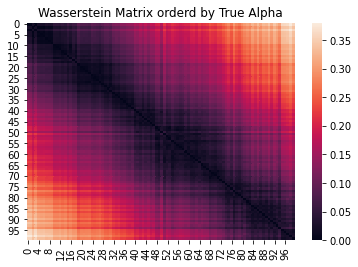

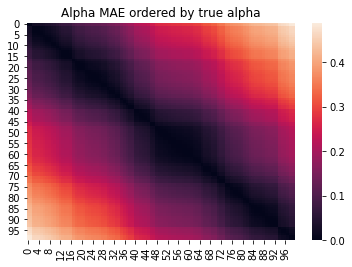

k:0    n=25
k:1    n=40
k:2    n=35


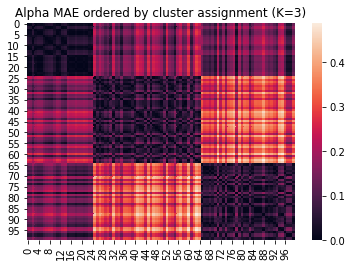

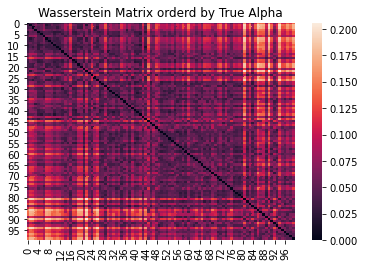

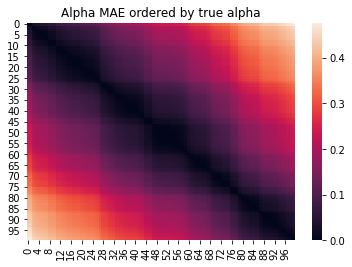

k:0    n=44
k:1    n=39
k:2    n=17


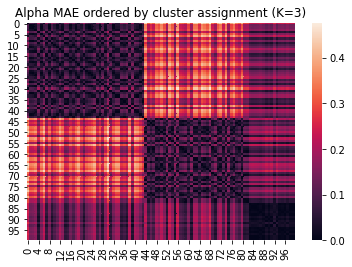

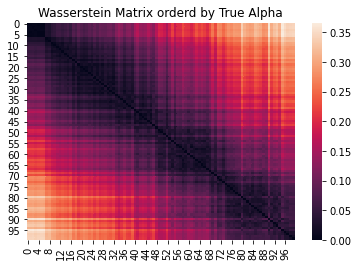

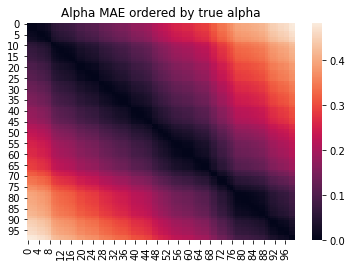

k:0    n=32
k:1    n=47
k:2    n=21


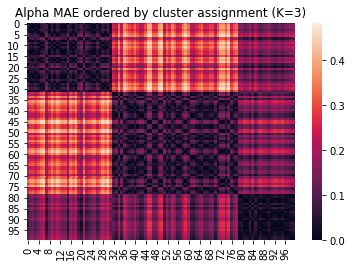

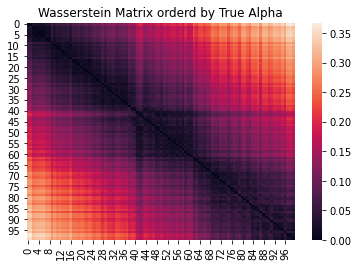

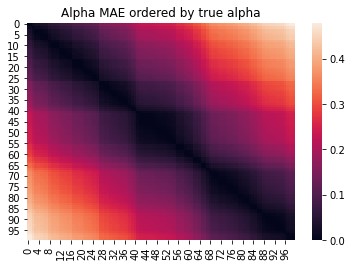

k:0    n=38
k:1    n=22
k:2    n=40


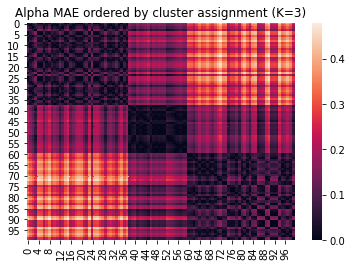

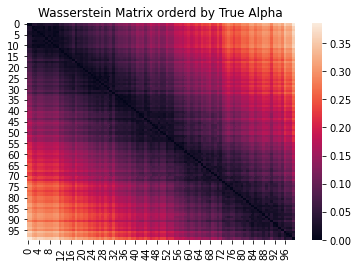

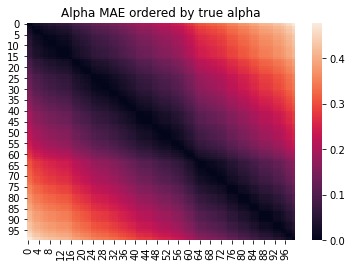

k:0    n=41
k:1    n=18
k:2    n=41


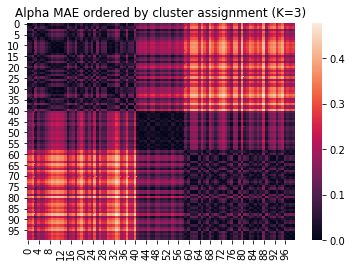

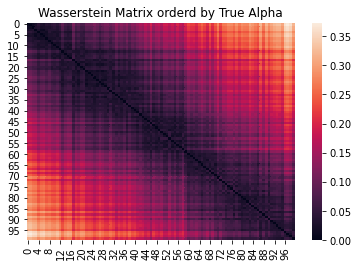

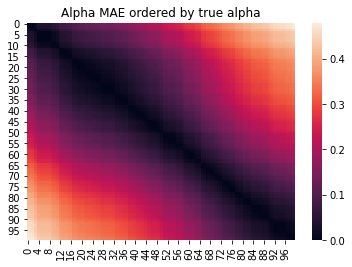

k:0    n=45
k:1    n=41
k:2    n=14


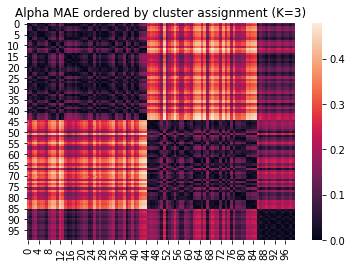

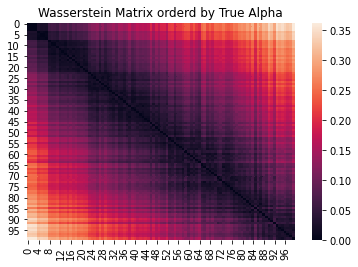

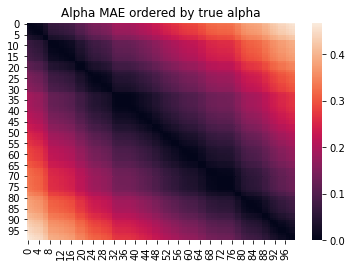

k:0    n=33
k:1    n=21
k:2    n=46


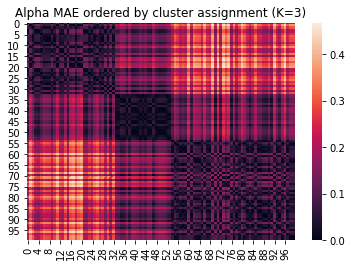

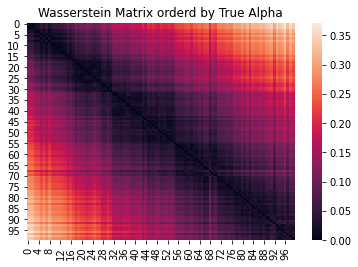

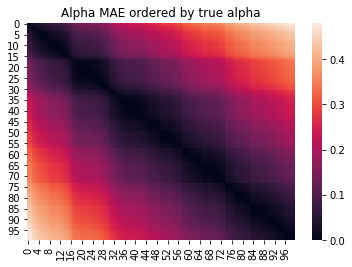

k:0    n=42
k:1    n=34
k:2    n=24


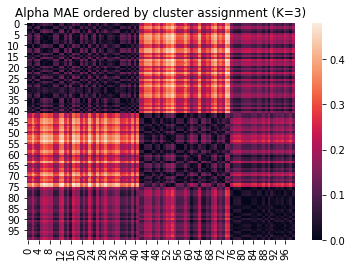

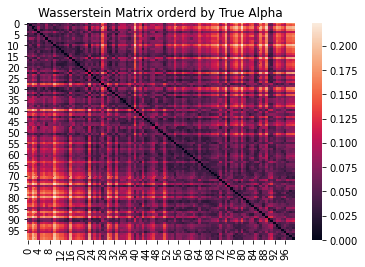

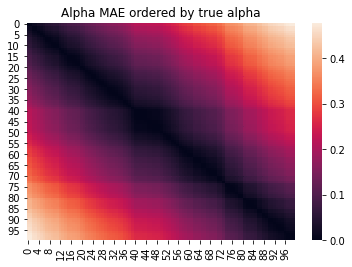

k:0    n=39
k:1    n=43
k:2    n=18


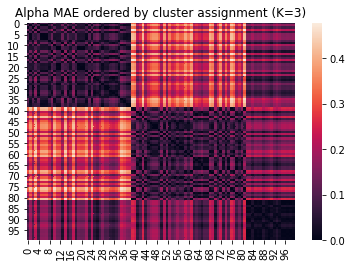

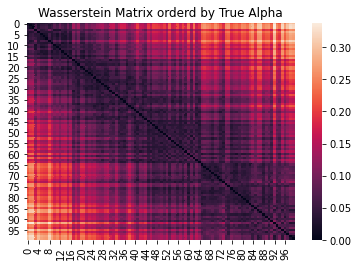

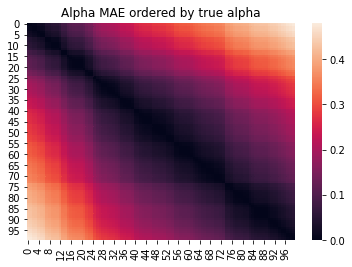

k:0    n=35
k:1    n=45
k:2    n=20


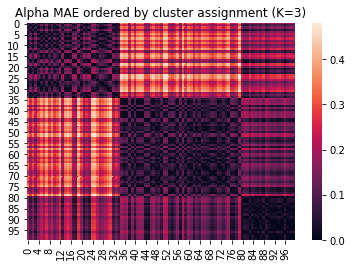

In [7]:
# hide
for rep in tqdm(range(10),total=10,leave=False, desc="dataset rep"):
    ds = buildDataset(100,alphaDistr=lambda: np.random.uniform(0.01,0.5))
    ds = addTransformScores(ds)
    # compute dist mat
    wassMat = getWassersteinMat(ds)
    order = np.argsort(ds.trueAlphas.flatten())
    plt.figure()
    sns.heatmap(wassMat[order][:,order])
    plt.title("Wasserstein Matrix orderd by True Alpha")
    plt.show()
    
    plt.figure()
    sns.heatmap(getOptimalAdjacency(ds.trueAlphas)[order][:,order])
    plt.title("Alpha MAE ordered by true alpha")
    plt.show()
    # find partition using Louvain alg
    g = nx.from_numpy_array(1 / np.exp(wassMat))
    partition = community_louvain.best_partition(g)
    values = np.array(list(partition.values()))
    plt.figure()
    for k in np.unique(values):
        print("k:{}    n={}".format(k, (values == k).sum()))
    clusterorder = np.argsort(values)
    sns.heatmap(getOptimalAdjacency(ds.trueAlphas)[clusterorder][:,clusterorder])
    plt.title("Alpha MAE ordered by cluster assignment (K={})".format(len(np.unique(values))))
    plt.show()
    ds.clusters = [np.where(values  == v)[0] for v in np.unique(values)]    
    ds.alphaHats, ds.curves = getBagAlphaHats(ds,10)
    ds.clusterAlphaHat, ds.clusterCurves = getCliqueAlphaHats(ds,ds.clusters, numbootstraps=10)

    ds.alphaPrime = getAlphaPrime(ds.clusters, ds.clusterAlphaHat)

    globalAlphaHat,_ = getCliqueAlphaHats(ds, [np.arange(ds.N)], numbootstraps=10)

    primeAEs.append(np.abs(ds.alphaPrime - ds.trueAlphas))
    localAEs.append(np.abs(ds.alphaHats - ds.trueAlphas))
    baselineAEs.append(np.abs(ds.trueAlphas - globalAlphaHat.mean()))

In [8]:
# hide
np.mean(primeAEs), np.mean(localAEs), np.mean(baselineAEs)

(0.15678428531516772, 0.09755037174843556, 0.1310386350558893)